## PART ZERO: LOAD LIBRARIES

In [6]:
# Install all required libraries 
%pip install numpy pandas seaborn matplotlib scipy statsmodels

Note: you may need to restart the kernel to use updated packages.


In [17]:
# Load Relevant Python Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
from scipy.stats import zscore

In [34]:
RAW_DATA_PATH = "../data/raw/Employee_Performance.csv"
PROCESSED_DATA_PATH = "../data/processed/employee_performance_cleaned.csv"

## PART ONE: EXPLORING DATA AND TESTING HYPOTHESES

To gain insights into how various departments within the organization assess and evaluate different aspects of the workplace, your task is to **perform an analysis** aimed at **investigating potential variations in employee performance rating across departments**. If such variations exist, your goal is to **identify the department(s) that exhibit notably higher or lower ratings.**

### 2.1 Data Preparation and Exploration
**Section One:** *Perform initial data exploration to understand the characteristics of the dataset. This includes summary statistics, data distribution etc.*

**Load the dataset**

In [35]:
# Load the dataset
df = pd.read_csv(RAW_DATA_PATH)

####  2.1.1 First Look at the Data (First Five Entries): 

In [36]:
# Print the first few rows of the dataset.
print('-----First Few Rows of Employee Performance Dataset:')
print(df.head())

-----First Few Rows of Employee Performance Dataset:
   EmployeeID Department  Gender  Experience  TrainingHours  \
0        1001         IT    Male           4              5   
1        1002  Marketing  Female           0             50   
2        1003      Sales    Male           0              5   
3        1004         HR    Male           1              5   
4        1005         HR  Female           9              5   

   PerformanceRating  Salary  
0               1.00   19000  
1               5.50    6900  
2               1.00    6000  
3               1.00    6000  
4               1.04   38000  


#### 2.1.2 Dataset Overview and Structure 

In [37]:
# Dateset Basic Information
print('\n-----Dataset Basic Information:')
print(df.info())


-----Dataset Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EmployeeID         1468 non-null   int64  
 1   Department         1468 non-null   object 
 2   Gender             1468 non-null   object 
 3   Experience         1468 non-null   int64  
 4   TrainingHours      1468 non-null   int64  
 5   PerformanceRating  1468 non-null   float64
 6   Salary             1468 non-null   int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 80.4+ KB
None


#### 2.1.3 Identifying and Handling Missing Data 

In [51]:
# Get the total number of rows
total_rows = df.shape[0]

# Find missing values
num_missingval = df.isnull().sum()
print("-----Number of Missing Values:")
print(num_missingval)

# Percentage of missing values
percent_missingval = (num_missingval / total_rows) * 100
print("\n-----Percentage of Missing Values:")
print(round(percent_missingval, 2))

-----Number of Missing Values:
EmployeeID             0
Department             0
Gender                 0
Experience             0
TrainingHours          0
PerformanceRating      0
Salary                 0
Experience_Category    0
dtype: int64

-----Percentage of Missing Values:
EmployeeID             0.0
Department             0.0
Gender                 0.0
Experience             0.0
TrainingHours          0.0
PerformanceRating      0.0
Salary                 0.0
Experience_Category    0.0
dtype: float64


#### 2.1.4 Identifying and Handling Duplicates 

In [39]:
# Find duplicate rows
num_duplicates = df.duplicated().sum()
print("-----Number of Duplicate Rows:", num_duplicates)

-----Number of Duplicate Rows: 0


#### 2.1.5 Identifying and Handling Outliers 

In [27]:
# Identify numerical data
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("-----Numerical Columns:")
print(numerical_cols)

-----Numerical Columns:
['EmployeeID', 'Experience', 'TrainingHours', 'PerformanceRating', 'Salary']


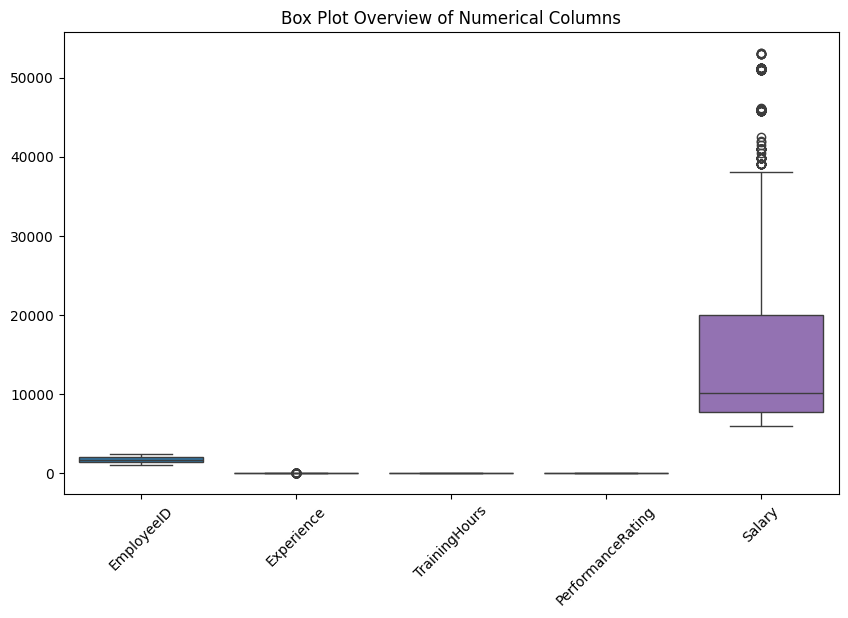

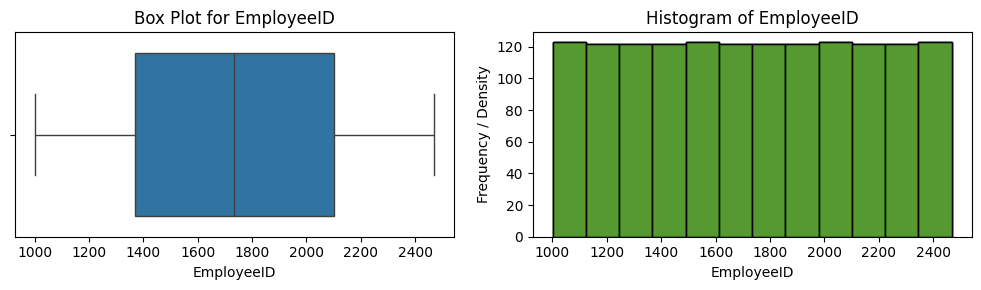

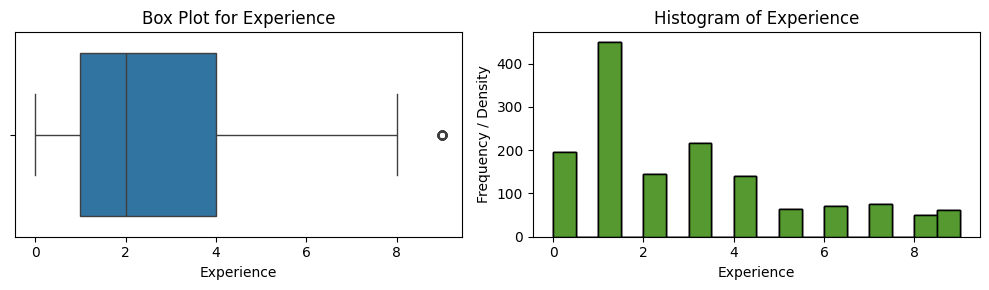

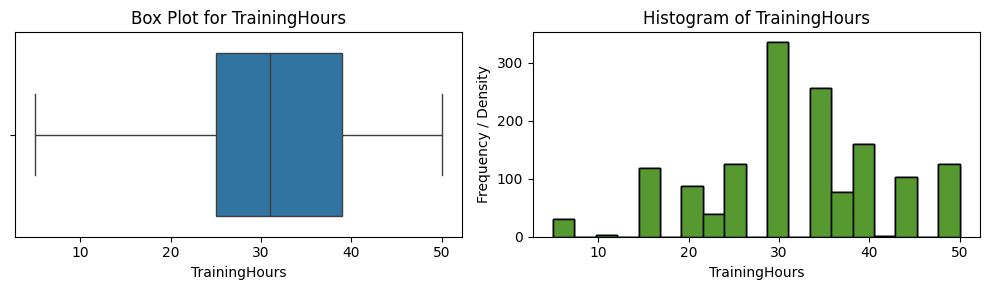

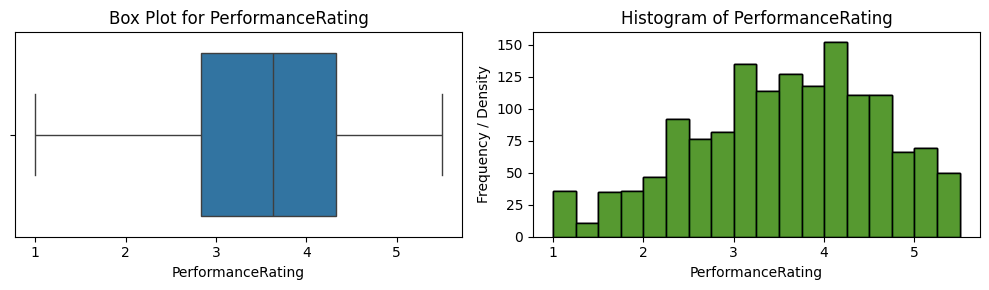

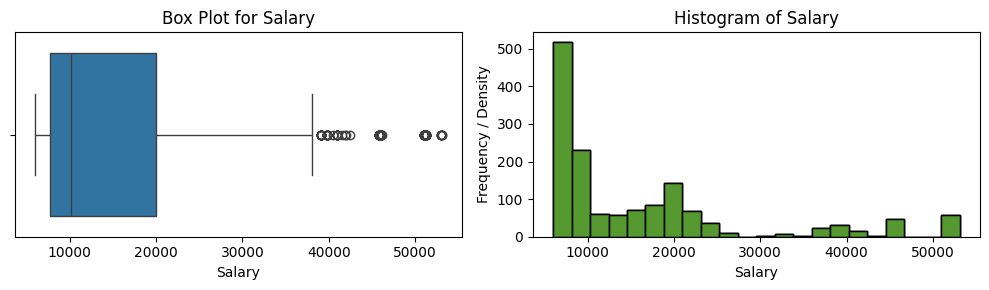

In [28]:
# Visualising Overview of Numerical Columns to identify potential outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_cols])
plt.title("Box Plot Overview of Numerical Columns")
plt.xticks(rotation=45)
plt.show

# Visualising Individual Box Plots for closer look at data
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))

    # Box Plot Subplot
    sns.boxplot(data=df, x=col, ax=axes[0])
    axes[0].set_xlabel(col)
    axes[0].set_title(f"Box Plot for {col}")

    # Histogram
    sns.histplot(df[col].dropna())
    sns.histplot(data=df, x=col, kde=False, ax=axes[1])

    sns.histplot(data=df, x=col, kde=False, ax=axes[1])
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Frequency / Density")
    axes[1].set_title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

#### Statistical Method – Skew: 

In [40]:
# Calculating values for skewness
skewness = df[numerical_cols].skew()
print("-----Skewness of Numerical Data:")
print(skewness)

# Skewness Values
# -0.5 < x < 0.5 = Almost symmetrical
# -1 < x < -0.5 = Negatively skewed (moderate)
# 0.5 < x < 1 = Positively skewed (moderate)
# x < -1 = Highly negatively skewed
# 1 < x = Highly positively skewed

-----Skewness of Numerical Data:
EmployeeID           0.000000
Experience           0.945471
TrainingHours       -0.380741
PerformanceRating   -0.309557
Salary               1.631322
dtype: float64


#### Statistical Method – IQR: 

In [41]:
# Select numeric columns for outlier detection
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

In [42]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for outlier detection
iqr_outlier_mask = (df[numeric_cols] < lower_bound) | (df[numeric_cols] > upper_bound)

# Extract rows where outliers are present
iqr_outliers = df[numeric_cols][iqr_outlier_mask.any(axis=1)]

# Number of outliers in each column
iqr_outlier_counts = iqr_outlier_mask.sum()

# Percentage of outliers in each column
iqr_outliers_percentage = (iqr_outlier_counts / len(df)) * 100

# Summary table
iqr_outlier_summary = pd.DataFrame(
    {
        "Column": numeric_cols,
        "Number of Outliers": iqr_outlier_counts,
        "Percentage of Outliers": iqr_outliers_percentage.round(2),
    }
)

# Total row
iqr_total_outliers = iqr_outlier_counts.sum()
iqr_total_percentage = (iqr_total_outliers / (len(df) * len(numeric_cols))) * 100

iqr_summary_row = pd.DataFrame(
    {
        "Column": ["Total"],
        "Number of Outliers": [iqr_total_outliers],
        "Percentage of Outliers": [iqr_total_percentage.round(2)],
    }
)

# Append total row to summary
iqr_outlier_summary = pd.concat(
    [iqr_outlier_summary, iqr_summary_row], ignore_index=True
)

print("Summary of Outliers in the Dataset (IQR Method):")
print(iqr_outlier_summary)

Summary of Outliers in the Dataset (IQR Method):
              Column  Number of Outliers  Percentage of Outliers
0         EmployeeID                   0                    0.00
1         Experience                  61                    4.16
2      TrainingHours                   0                    0.00
3  PerformanceRating                   0                    0.00
4             Salary                 152                   10.35
5              Total                 213                    2.90


In [43]:
# Calculate Z-scores for each numeric column
z_scores = df[numeric_cols].apply(zscore)

threshold = 3

# Mask for outlier detection based on Z-scores
zscore_outlier_mask = (z_scores > threshold) | (z_scores < -threshold)

# Extract the rows where outliers are present
zscore_outliers = df[numeric_cols][zscore_outlier_mask.any(axis=1)]

# Number of outliers for each column
zscore_outlier_counts = zscore_outlier_mask.sum()

# Percentage of outliers in each column
zscore_outliers_percentage = (zscore_outlier_counts / len(df)) * 100

# Summary table
zscore_outlier_summary = pd.DataFrame(
    {
        "Column": numeric_cols,
        "Number of Outliers": zscore_outlier_counts,
        "Percentage of Outliers": zscore_outliers_percentage.round(2),
    }
)

# Total row
zscore_total_outliers = zscore_outlier_counts.sum()
zscore_total_percentage = (zscore_total_outliers / (len(df) * len(numeric_cols))) * 100

zscore_summary_row = pd.DataFrame(
    {
        "Column": ["Total"],
        "Number of Outliers": [zscore_total_outliers],
        "Percentage of Outliers": [zscore_total_percentage.round(2)],
    }
)

# Append total row to summary
zscore_outlier_summary = pd.concat(
    [zscore_outlier_summary, zscore_summary_row], ignore_index=True
)

print("Summary of Outliers in the Dataset (Z-score Method):")
print(zscore_outlier_summary)

Summary of Outliers in the Dataset (Z-score Method):
              Column  Number of Outliers  Percentage of Outliers
0         EmployeeID                   0                    0.00
1         Experience                   0                    0.00
2      TrainingHours                   0                    0.00
3  PerformanceRating                   0                    0.00
4             Salary                   7                    0.48
5              Total                   7                    0.10


#### Outlier Visualisation – Scatter Plot (IQR)  

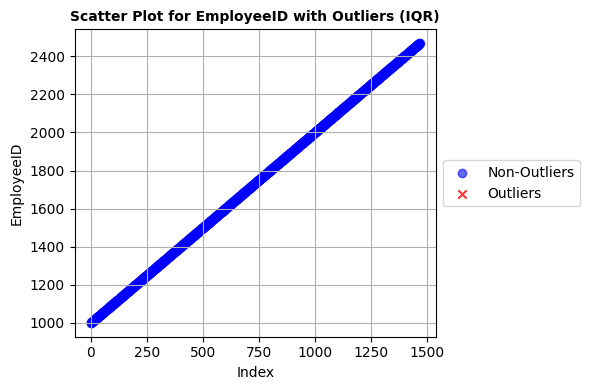

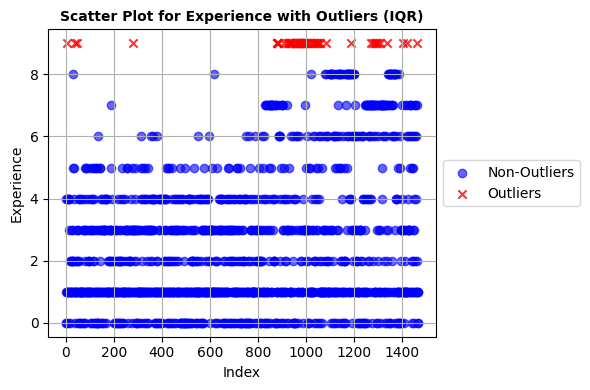

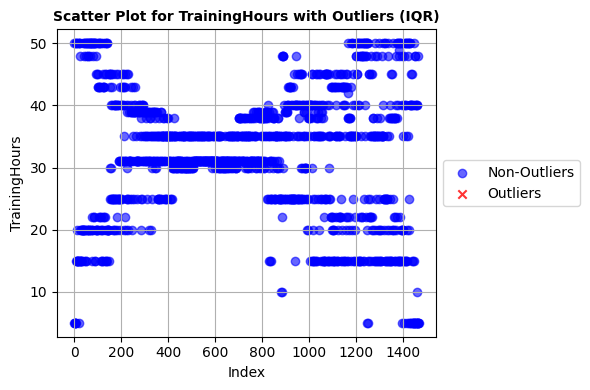

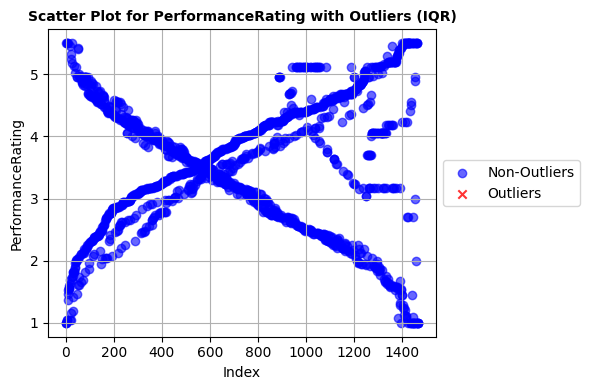

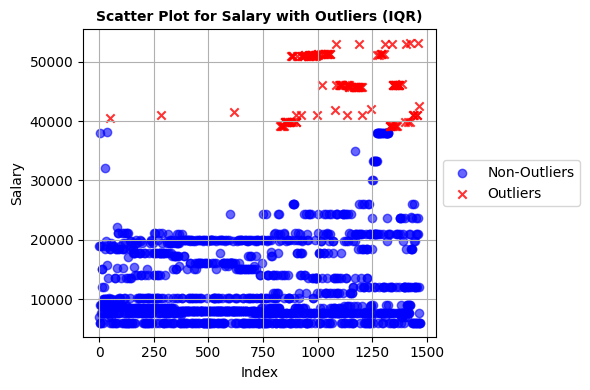

In [44]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(
        df.index[~iqr_outlier_mask[col]],
        df[col][~iqr_outlier_mask[col]],
        marker="o",
        label="Non-Outliers",
        color="blue",
        alpha=0.6,
    )
    plt.scatter(
        df.index[iqr_outlier_mask[col]],
        df[col][iqr_outlier_mask[col]],
        marker="x",
        label="Outliers",
        color="red",
        alpha=0.8,
    )
    plt.xlabel("Index", fontsize=10)
    plt.ylabel(col, fontsize=10)
    plt.title(
        f"Scatter Plot for {col} with Outliers (IQR)", fontweight="bold", fontsize=10
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### 2.1.7 Summary Statistics 

In [45]:
summary_statistics = df.describe()

print("----Summary statistics in the dataset:\n")
print(summary_statistics)

----Summary statistics in the dataset:

        EmployeeID   Experience  TrainingHours  PerformanceRating  \
count  1468.000000  1468.000000    1468.000000        1468.000000   
mean   1734.500000     2.838556      32.144414           3.561512   
std     423.919411     2.527657      10.106029           1.044987   
min    1001.000000     0.000000       5.000000           1.000000   
25%    1367.750000     1.000000      25.000000           2.840000   
50%    1734.500000     2.000000      31.000000           3.630000   
75%    2101.250000     4.000000      39.000000           4.330000   
max    2468.000000     9.000000      50.000000           5.500000   

             Salary  
count   1468.000000  
mean   16107.623297  
std    12158.438481  
min     6000.000000  
25%     7700.000000  
50%    10100.000000  
75%    20000.000000  
max    53100.000000  


#### 2.1.8 Data Distribution and Visualization 

##### Visualize Distribution: Numerical Variables – Box Plots and Histogram with KDE:

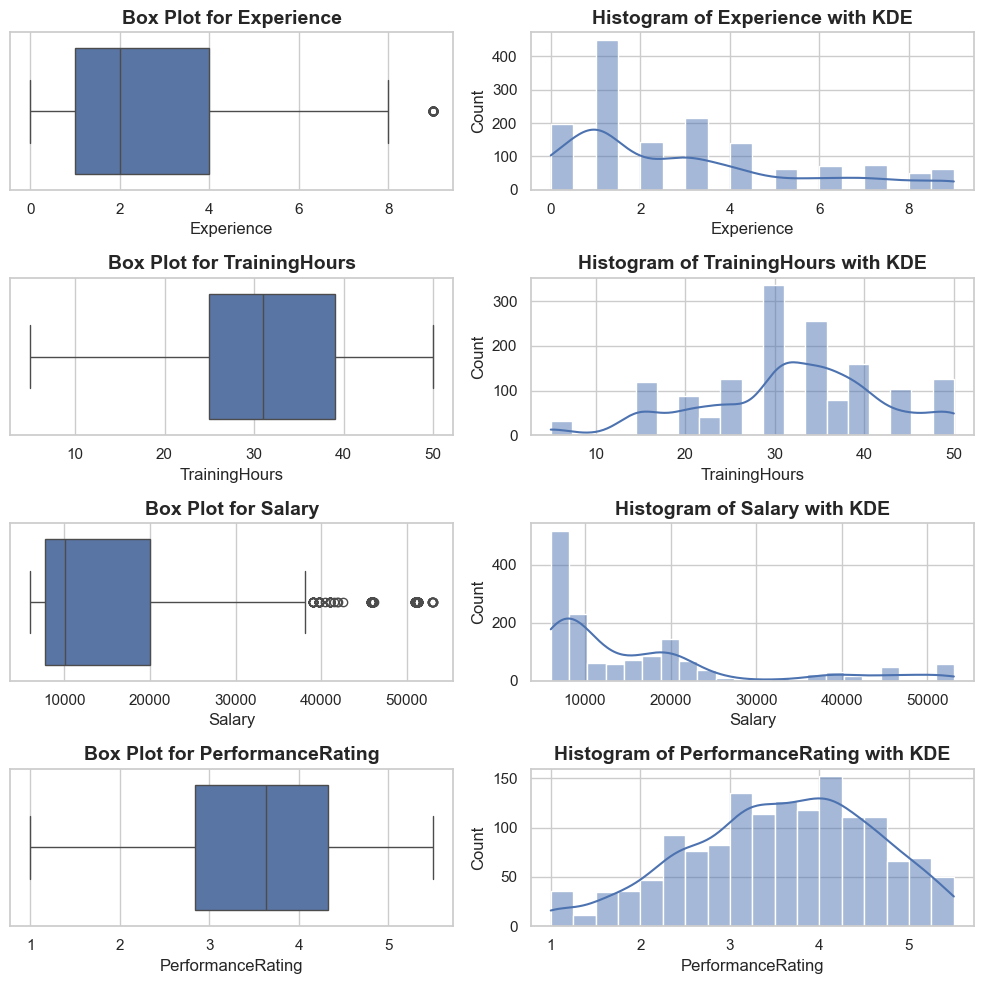

In [46]:
sns.set(style="whitegrid")

columns = ["Experience", "TrainingHours", "Salary", "PerformanceRating"]

plt.figure(figsize=(10, 10))

for i, col in enumerate(columns):
    # Box plot
    plt.subplot(len(columns), 2, 2 * i + 1)
    sns.boxplot(x=df[col], color=sns.color_palette()[0])
    plt.xlabel(col, fontsize=12)
    plt.title(f"Box Plot for {col}", fontweight="bold", fontsize=14)

    # Histogram
    plt.subplot(len(columns), 2, 2 * i + 2)
    sns.histplot(df[col], kde=True, color=sns.color_palette()[0])
    plt.title(f"Histogram of {col} with KDE", fontweight="bold", fontsize=14)

plt.tight_layout()
plt.show()

##### Visualize Distribution: Categorical Variables – Pie Chart and Bar Plot:

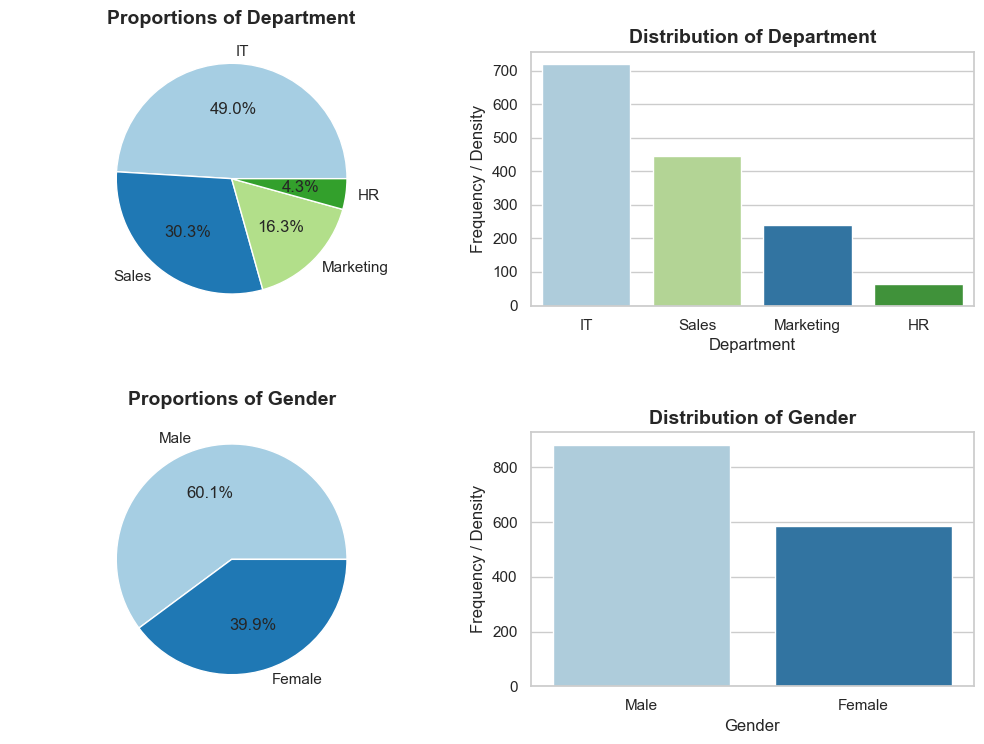

In [47]:
# Explore the distribution of categorical data
categorical_data = ['Department', 'Gender']
num_columns = len(categorical_data)
fig, axes = plt.subplots(num_columns, 2, figsize=(10, num_columns * 4))

for i, col in enumerate(categorical_data):
    # Pie Chart Subplot
    column_counts = df[col].value_counts()
    axes[i, 0].pie(
        column_counts, 
        labels=column_counts.index,
        autopct='%1.1f%%',
        startangle=0,
        colors=plt.cm.Paired.colors
    )
    axes[i, 0].set_title(f'Proportions of {col}', pad=20, fontweight='bold', fontsize=14)
    axes[i, 0].axis('equal')

    # Bar Plot Subplot
    sns.countplot(data=df, x=col, ax=axes[i, 1], palette='Paired', hue=df[col], legend=False, order=column_counts.index)
    axes[i, 1].set_title(f'Distribution of {col}', fontweight='bold', fontsize=14)
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequency / Density')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the overall layout
plt.subplots_adjust(hspace=0.5)  # Increase space between rows
plt.show()

#### 2.1.10 Multivariate Analysis: Visualising Experience vs. Performance Ratings Across Departments 

**Section Two:** *Perform multivariate analysis of data to visualize relationships between employees' years of experience on their performance ratings within different departments.*

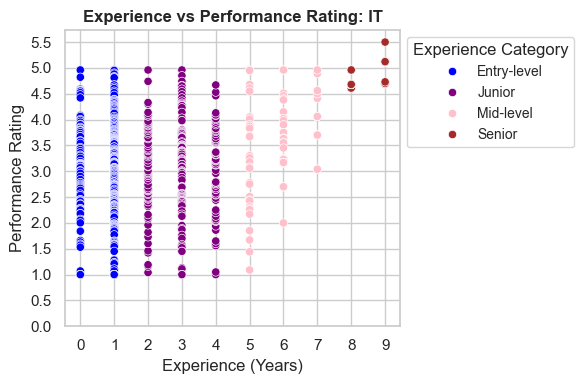

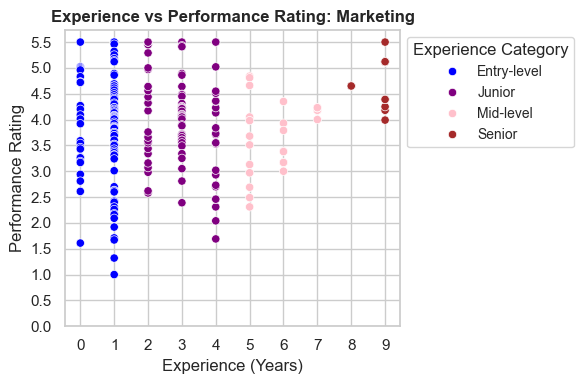

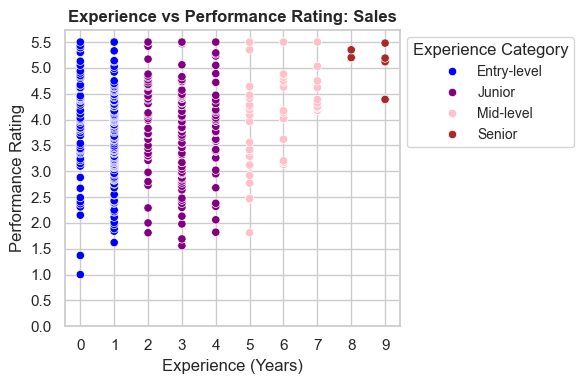

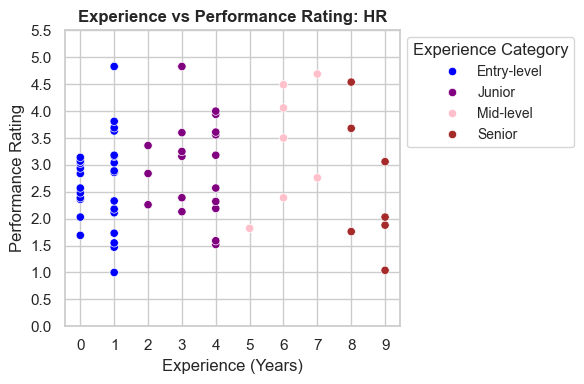

In [48]:
sns.set_theme(style="whitegrid")

# Categorize experience
def categorize_experience(years):
    if years >= 8:
        return "Senior"
    elif years >= 5:
        return "Mid-level"
    elif years >= 2:
        return "Junior"
    else:
        return "Entry-level"

# Apply categorization function to 'Experience' column
df["Experience_Category"] = df["Experience"].apply(categorize_experience)

# Get unique departments
departments = df["Department"].unique()

# Create the figures for each department 
for department in departments:
    plt.figure(figsize=(6, 4))
    dept_data = df[df["Department"] == department]

    sns.scatterplot(
        x="Experience",
        y="PerformanceRating",
        hue="Experience_Category",
        hue_order=["Entry-level", "Junior", "Mid-level", "Senior"],
        data=dept_data,
        palette={
            "Entry-level": "blue",
            "Junior": "purple",
            "Mid-level": "pink",
            "Senior": "brown",
        },
    )

    plt.title(
        f"Experience vs Performance Rating: {department}",
        fontsize=12,
        fontweight="bold",
    )
    plt.xlabel("Experience (Years)")
    plt.ylabel("Performance Rating")

    # x-ticks for experience in 1-year increments (0 to 9)
    plt.xticks(range(0, 10))
    # Set y-ticks for performance ratings in 0.5 increments up to 5.5
    plt.yticks([i * 0.5 for i in range(12)])

    plt.legend(
        title="Experience Category",
        bbox_to_anchor=(1.0, 1),
        loc="upper left",
        fontsize=10,
    )

    plt.tight_layout()
    plt.show()

### 2.2 Statistical Technique: Hypothesis Testing
**Section One:** *Perform the test using your dataset. Include the relevant outputs (F-statistic, p-value, critical value)*

#### 2.2.2 Assumptions of Analysis 

**Preparation of Data for Testing**

In [49]:
# Get unique values in the "Department" column
department_values = df['Department'].unique()

# Display the unique department values
print('-----Unique Departments:')
print(department_values)

-----Unique Departments:
['IT' 'Marketing' 'Sales' 'HR']


**Department Data Visualisation: Histogram with KDE**

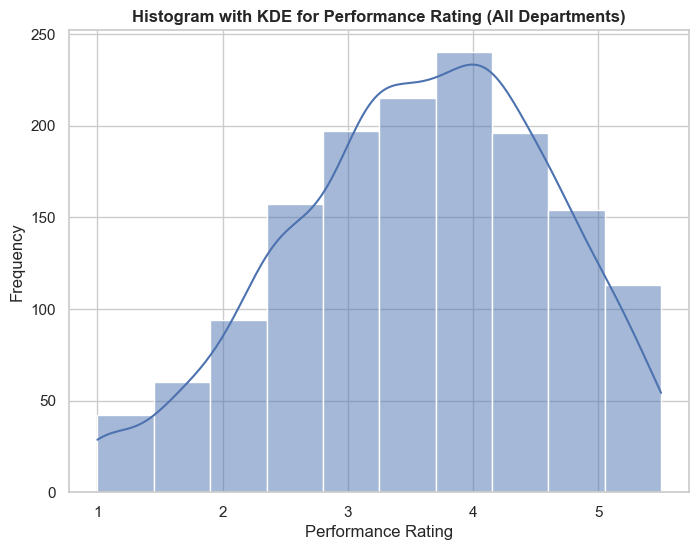

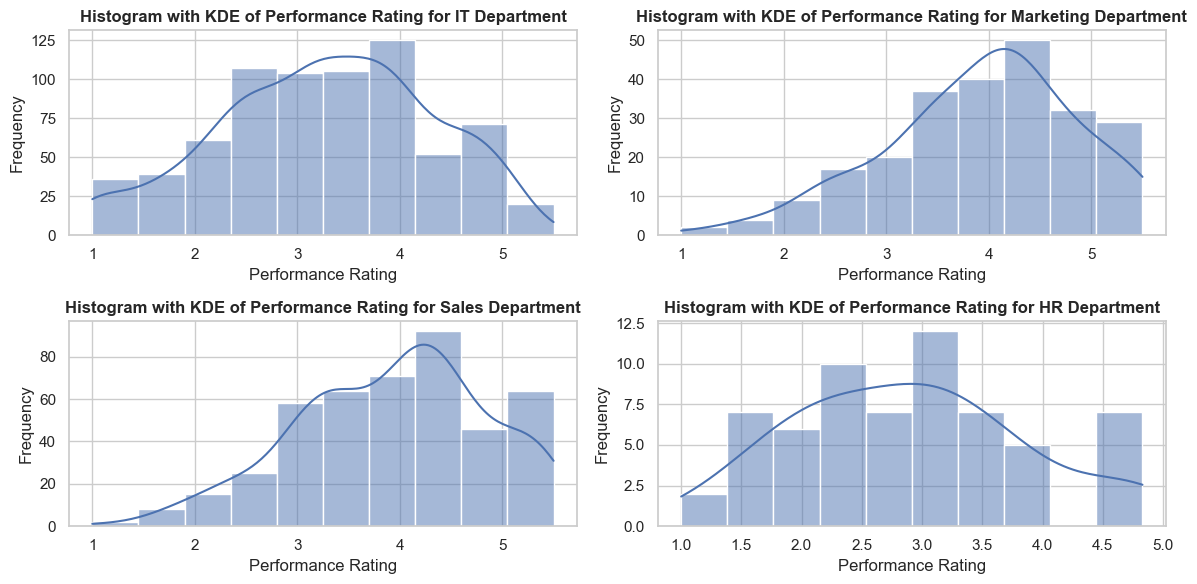

In [50]:
# Set the style for the plots
sns.set(style="whitegrid")

# Histogram with KDE of Performance Rating across all departments.
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='PerformanceRating', kde=True, bins=10)
plt.title(
    "Histogram with KDE for Performance Rating (All Departments)", fontweight="bold"
)
plt.xlabel('Performance Rating')
plt.ylabel('Frequency')
plt.show()

# Histogram with KDE of Peformance Ratings for each specific department.
plt.figure(figsize=(12, 6))

# Define the departments
department_groups = df['Department'].unique()

for department in department_groups:
    plt.subplot(2, 2, department_groups.tolist().index(department) + 1)
    sns.histplot(data=df[df['Department'] == department], x='PerformanceRating', kde=True, bins=10)
    plt.title(f'Histogram with KDE of Performance Rating for {department} Department', fontweight='bold')
    plt.xlabel('Performance Rating')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 2.3 Statistical Technique; Hypothesis Testing 

#### 2.3.2 Results of Hypothesis Testing 

**One-way ANOVA Testing**

In [77]:
# Perform one-way ANOVA on the performance ratings of each department
grouped_data = [df[df['Department'] == department]['PerformanceRating'] for department in department_values]
f_statistic, p_value = stats.f_oneway(*grouped_data)

In [79]:
# Store Department counts in an empty dictionary
department_counts = {}

# Loop through unique department values
for department in df['Department'].unique():
    # Count the occurrences of the current department and store it in the dictionary
    count = len(df[df['Department'] == department])
    department_counts[department] = count

# Print the department counts
print("-----Department Counts:")
for department, count in department_counts.items():
    print(f"{department} Department: {count} observations")
    
# Display results of the one-way ANOVA test.
print("\n-----One-way ANOVA Results (p-value):")
print(f"F-statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret results according to alpha value.
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: p-value is less than alpha value. There is a statistically significant difference in performance ratings across one or more departments.\nReject the Null Hypothesis.")
else:
    print("\nConclusion: p-value is greater than alpha value. There is no statistically significant difference in performance ratings across departments.\nFail to reject the Null Hypothesis.")

-----Department Counts:
IT Department: 720 observations
Marketing Department: 240 observations
Sales Department: 445 observations
HR Department: 63 observations

-----One-way ANOVA Results (p-value):
F-statistic: 61.45
P-value: 0.0000

Conclusion: p-value is less than alpha value. There is a statistically significant difference in performance ratings across one or more departments.
Reject the Null Hypothesis.


In [81]:
# Degrees of freedom
df_between = len(department_values) - 1
df_within = len(df) - len(department_values)

# Calculate the critical F-value based on alpha and degrees of freedom
critical_f_value = stats.f.ppf(1 - alpha, df_between, df_within)

# Print the results
print("-----One-way ANOVA Results (f-statistic):")
print(f"F-statistic: {f_statistic:.2f}")
print(f"Critical F-value: {critical_f_value:.2f}")
print(f"P-value: {p_value:.4f}")

# Compare F-statistic to the critical F-value and make the decision
if f_statistic > critical_f_value:
    print("\nConclusion: f-statistic is greater than the f-critical value.  There is a statistically significant difference in performance ratings across one or more departments. Reject the Null Hypothesis.")
else:
    print("\nConclusion: f-statistic is less than the f-critical value. There is no statistically significant difference in performance ratings across departments. Fail to reject the Null Hypothesis.")

-----One-way ANOVA Results (f-statistic):
F-statistic: 61.45
Critical F-value: 2.61
P-value: 0.0000

Conclusion: f-statistic is greater than the f-critical value.  There is a statistically significant difference in performance ratings across one or more departments. Reject the Null Hypothesis.


**Tukey's HSD (Honest Significant Difference) Post Hoc Test**

In [84]:
# Tukey's HSD post hoc test
multicomp = MultiComparison(df['PerformanceRating'], df['Department'])
result = multicomp.tukeyhsd()

# Display the results
print("-----Tukey's HSD Post Hoc Test:")
print(result)

-----Tukey's HSD Post Hoc Test:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
       HR        IT   0.3715 0.0217  0.0384 0.7047   True
       HR Marketing    1.027    0.0  0.6681  1.386   True
       HR     Sales   1.0256    0.0  0.6843 1.3669   True
       IT Marketing   0.6555    0.0  0.4665 0.8445   True
       IT     Sales   0.6541    0.0  0.5012  0.807   True
Marketing     Sales  -0.0014    1.0 -0.2044 0.2017  False
---------------------------------------------------------


## PART TWO: REGRESSION ANALYSIS

Based on your understanding of the scenario and the employee-related information provided in the dataset, your task is to **explore and uncover the underlying relationships between various parameters associated with employee performance.** Utilize regression analysis to **reveal these relationships and insights into how different factors may influence or correlate with employee performance ratings.** 

### 3.1 Identify Potential Predictor Variables 

**Correlation Heatmap for Numerical Columns**

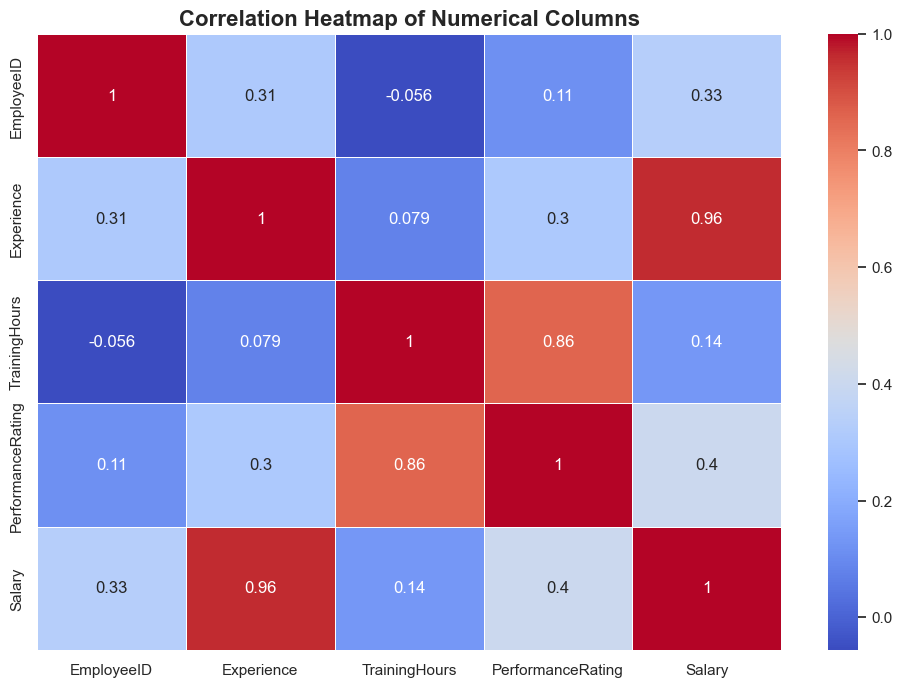

In [94]:
numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns

# Correlation Matrix 
corr_matrix = df[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Columns", fontsize=16, fontweight="bold")
plt.show()

**Select Potential Predictor Variables and the Target Variable (Performance Rating)**

In [97]:
# Select predictor variables and the target variable
# Select independent variables
X = df[['Experience', 'TrainingHours', 'Salary']]
# Dependent variable
y = df['PerformanceRating']

### 3.2 Assumptions for Regression Analysis 

#### 3.2.1 Multicollinearity 

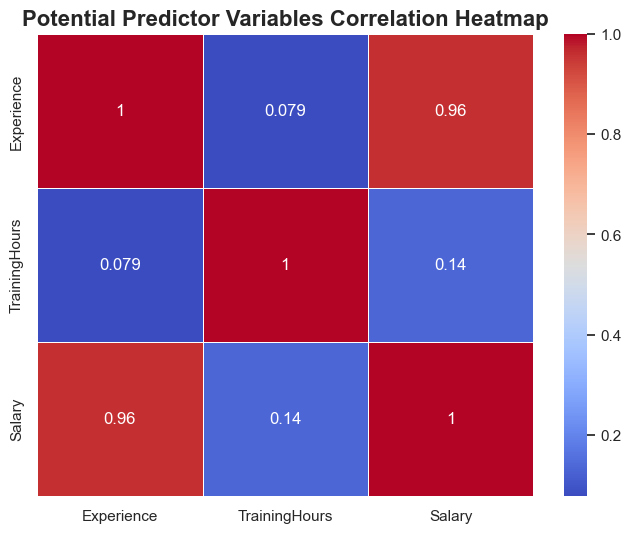

In [101]:
# Heat Map to check for multicollinearity
corr_matrix = X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Potential Predictor Variables Correlation Heatmap", fontsize=16, fontweight="bold")
plt.show()

**Check for Linear Relationships**

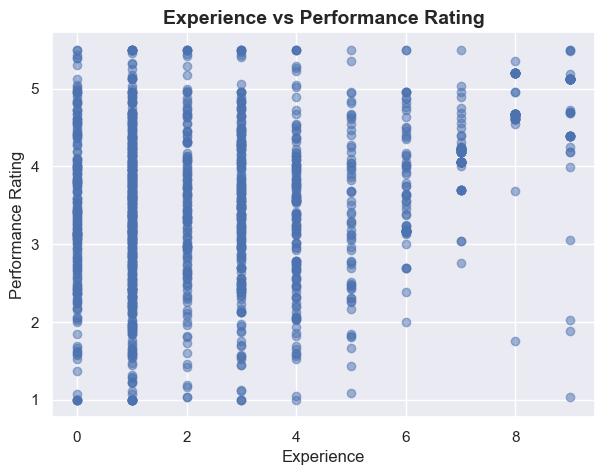

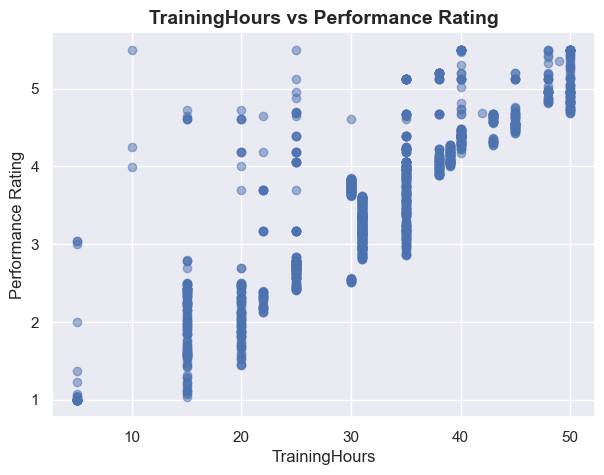

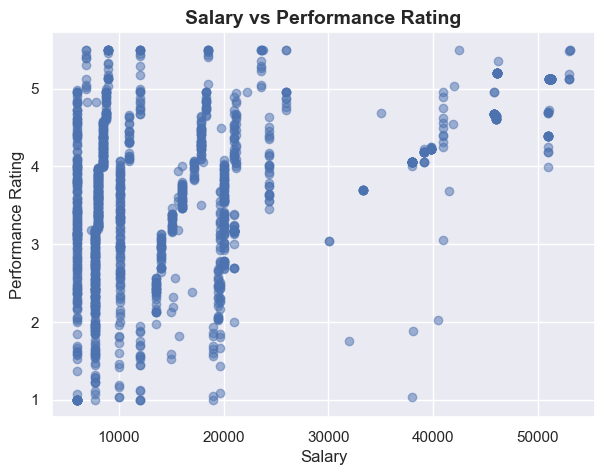

In [104]:
sns.set_theme()

for col in X.columns:
    plt.figure(figsize=(7, 5))
    plt.scatter(X[col], y, alpha=0.5)
    plt.title(f"{col} vs Performance Rating", fontsize=14, fontweight="bold")
    plt.xlabel(col)
    plt.ylabel("Performance Rating")
    plt.show()

**Select final predictor variables**

In [107]:
# Select predictor variables and the target variable
# Select independent variables
X = df[['Experience', 'TrainingHours']]
# Dependent variable
y = df['PerformanceRating']

### 3.3 Regression Analysis 

#### 3.3.1 Multiple Linear Regression Model 

In [111]:
# Add a constant term to the predictor variables
X = sm.add_constant(X)
# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()
# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      PerformanceRating   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     2837.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        22:14:13   Log-Likelihood:                -984.63
No. Observations:                1468   AIC:                             1975.
Df Residuals:                    1465   BIC:                             1991.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4880      0.043     11.446

### 3.4 Assumptions of Linear Regression 

### 3.4.1 Normality of Residuals 

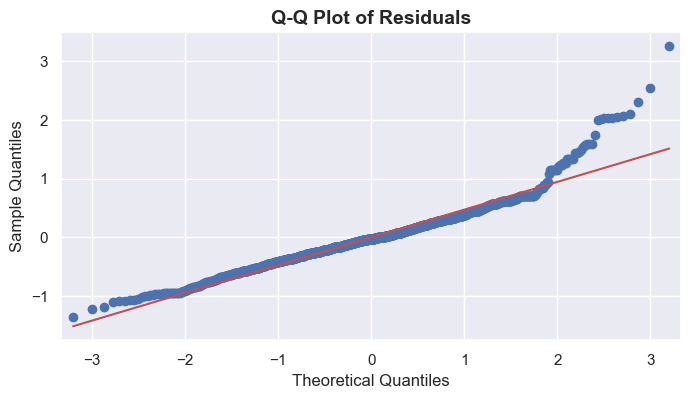

-----Anderson-Darling Statistic:
 10.5854340041451

-----Critical Values:
 [0.574 0.654 0.785 0.916 1.089]

-----Significance Levels:
 [15.  10.   5.   2.5  1. ]


In [115]:
# Residual plot for normality check

# Get the residuals
residuals = model.resid

# Create a Q-Q plot to check for normality
fig, ax = plt.subplots(figsize=(8, 4))
sm.qqplot(residuals, line='s', ax=ax)
plt.title("Q-Q Plot of Residuals", fontsize=14, fontweight="bold")
plt.show()

# Perform the Anderson-Darling test for normality
result = stats.anderson(residuals, dist='norm')

# Extract the test statistic, critical values, and significance levels
ad_statistic = result.statistic
ad_critical_values = result.critical_values
ad_significance_levels = result.significance_level

print("-----Anderson-Darling Statistic:\n", ad_statistic)
print("\n-----Critical Values:\n", ad_critical_values)
print("\n-----Significance Levels:\n", ad_significance_levels)

#### 3.4.2 Homoscedasticity 

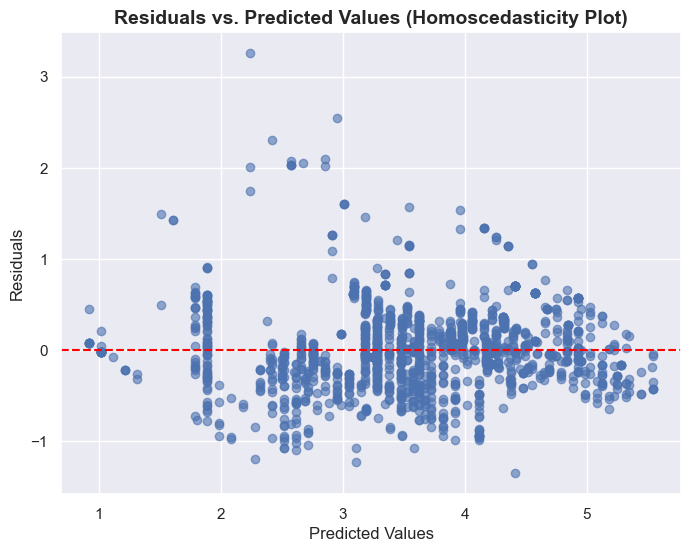

In [118]:
# Homoscedasticity check

# Get the predicted (fitted) values from the model
predicted_values = model.fittedvalues

# Get the residuals from the model
residuals = model.resid

# Create a scatterplot of residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Homoscedasticity Plot)", fontsize=14, fontweight="bold")
plt.show()